Open this notebook in Google Colab by clicking the link below:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/relmonta/lorenz96/blob/main/lorenz96_surrogate.ipynb)

# Practical: Using neural networks to learn surrogate models for chaotic systems
Author: Rachid El Montassir


- This notebook is inspired by the lecture notes of the course ["Introduction to the principles and methods of data assimilation in the geosciences"](https://cerea.enpc.fr/HomePages/bocquet/teaching/assim-mb-en-0.52.pdf) by M. Bocquet and A. Farchi.

The aim of this lab is to introduce and compare different neural network architectures for modelling the dynamics of a chaotic system — the **Lorenz-96 model** — with a focus on **embedding physical structure into neural networks**. Through this exercise, you will learn how simple architectural choices (e.g. convolutions or integration schemes) can dramatically affect the predictive skill of a learned model.

## The Lorenz-96 System

We consider the classical Lorenz-96 system of dimension $N_x$, governed by:

$$
\frac{dx_i}{dt} = (x_{i+1} - x_{i-2})x_{i-1} - x_i + F
$$

where $F$ is a forcing parameter (typically $F = 8$), and indices are interpreted modulo $N_x$ (periodic boundary conditions). The system exhibits chaotic behaviour and serves as a toy model for high-dimensional, non-linear geophysical dynamics.

In [1]:
! git clone https://github.com/relmonta/lorenz96.git
! pip install cmocean

Cloning into 'lorenz96'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 46 (delta 15), reused 40 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 10.14 MiB | 25.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 5.0 MB/s eta 0:00:00


In [2]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import cmocean
import os
from lorenz96.lorenz96_utils import Lorenz96, plot_lorenz96_trajectory, preprocess_dataset
from lorenz96.lorenz96_utils import PATH

## Models

### 1. Simple feedforward neural network
A simple feedforward neural network that takes the state $x_t$ as input and outputs the state $x_{t+1}$ at the next time step. The model is trained to minimize the mean squared error between the predicted and true states.

In [3]:
class NaiveNetwork(nn.Module):
    def __init__(self, Nx, num_layers=4):
        super(NaiveNetwork, self).__init__()
        self.Nx = Nx
        self.sequential = nn.Sequential(
            nn.Linear(Nx, 128),
            nn.ReLU(),
            *[
                nn.Sequential(
                    nn.Linear(128, 128),
                    nn.ReLU()
                ) for _ in range(num_layers - 2)
            ])
        self.linear = nn.Linear(128, Nx)

    def forward(self, x):
        x = self.sequential(x)
        x = self.linear(x)
        return x

    def predict(self, x, steps=1):
        for _ in range(steps):
            x = self.forward(x)
        return x

### Training
The model is trained using the Adam optimizer with a starting learning rate of $10^{-3}$ and a batch size of 64. The training is performed for 100 epochs, and the model is evaluated on a validation set after each epoch. The best model is saved based on the validation loss.

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, mean, std, device='cuda',
                 model_type='hybrid', patience=15, dt=0.01, F=8.0):
        self.dt = dt
        self.F = F
        self.Nx = model.Nx
        self.model_type = model_type
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.mean = mean
        self.std = std
        self.device = device
        self.patience = patience
        self.model.to(self.device)

    def train(self, epochs=20, lr=1e-3):
        print(f"Training on device: {self.device}")
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        sstep = epochs // 6
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=sstep, gamma=0.5)  # Reduce LR every 10 epochs
        losses = {'train': [], 'val': []}

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for x, y in self.train_loader:
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                loss = criterion(pred - x, y - x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            scheduler.step()
            losses['train'].append(train_loss / len(self.train_loader))

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x, y in self.val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    pred = self.model(x)
                    loss = criterion(pred - x, y - x)
                    val_loss += loss.item()
            val_loss /= len(self.val_loader)
            losses['val'].append(val_loss)

            print(f"[Epoch {epoch+1}] Train loss: {train_loss/len(self.train_loader):.4e} | "
                  f"Val loss: {val_loss:.4e}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), os.path.join(PATH,
                           f'{self.model_type}/best_dt{self.dt}_Nx{self.Nx}_F{self.F}_network.pth'))
                # print(
                #     f"Best model saved as {self.model_type}/best_dt{self.dt}_Nx{self.Nx}_F{self.F}_network.pth")
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping triggered.")
                    break

        self._plot_losses(losses)
        print(f"Final model saved as {self.model_type}/dt{self.dt}_Nx{self.Nx}_F{self.F}_network.pth")
        torch.save(self.model.state_dict(), os.path.join(PATH,
                   f'{self.model_type}/dt{self.dt}_Nx{self.Nx}_F{self.F}_network.pth'))

    def _plot_losses(self, losses):
        plt.figure(figsize=(10, 5))
        plt.plot(losses['train'], label='Train loss')
        plt.plot(losses['val'], label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{PATH}/{self.model_type}/{self.model_type}/training_loss.png', dpi=300)
        plt.show()

### Inference

In [5]:
class Inference:
    def __init__(self, model, mean, std, device='cuda', model_type='hybrid'):
        self.model_type = model_type
        self.model = model
        self.mean = mean
        self.std = std
        self.device = device
        self.model.to(self.device)
        self.model.eval()

    @torch.no_grad()
    def predict_trajectory(self, data_set, steps=40, Nx=40):
        x_val = data_set[0][0]  # Get the first sample
        x_val = x_val.unsqueeze(0).to(self.device)  # Add batch dimension
        predicted_trajectory = np.zeros((steps, Nx))

        for t in range(steps):
            x_val = self.model.predict(x_val, steps=1)
            x_val_out = x_val.cpu().numpy() * self.std + self.mean  # Denormalise
            predicted_trajectory[t] = x_val_out

        self._plot_trajectory(predicted_trajectory,
                              title=f'{self.model_type.capitalize()} model predicted', vmin=-10, vmax=15)
        # plot validation trajectory
        val_trajectory = np.zeros((steps, Nx))
        for t in range(steps):
            x_val = data_set[t+1][0]
            val_trajectory[t] = x_val.numpy() * self.std + self.mean
        self._plot_trajectory(val_trajectory, title='True', vmin=-10, vmax=15)
        # plot the error
        error = predicted_trajectory - val_trajectory
        self._plot_trajectory(error, title=f'{self.model_type.capitalize()} model error',
                              vmin=-15, vmax=15)

    def _plot_trajectory(self, trajectory, title='Predicted', vmin=None, vmax=None):
        if vmin is not None and vmin == -vmax:
            cmap = cmocean.cm.balance
        else:
            cmap = cmocean.cm.curl
        plt.figure(figsize=(10, 5))
        plt.imshow(trajectory.T, aspect='auto', cmap=cmap,
                   origin='lower', interpolation='spline36', vmin=vmin, vmax=vmax)
        cbar_label = 'Error value' if 'Error' in title else 'State value'
        plt.colorbar(label=cbar_label)
        plt.xlabel('Time step')
        plt.ylabel('Lorenz96 variables')
        plt.title(f'{title} Lorenz-96 trajectory')
        plt.tight_layout()
        plt.savefig(
            f'{PATH}/{title.replace(" ", "_").lower()}_traj.png', dpi=300)
        plt.show()


Dataset loaded from lorenz96/outputs/lorenz96_dataset_Nt10000_Nx40_F8.0.npz


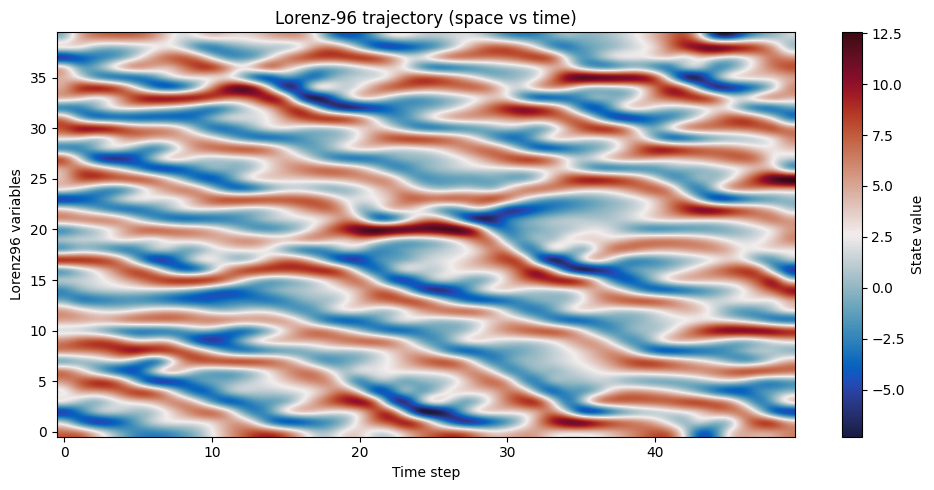

In [ ]:
Nt_train = 10000
Nx = 40
dt = 0.01
F = 8.0
# Use double precision, simple precision could also be used
torch.set_default_dtype(torch.float64)
true_model = Lorenz96(Nx=Nx, dt=dt, F=F, integrator='rk4')
xt = true_model.generate_dataset(
    Nt_train=Nt_train, Nt_spinup=1000, seed=42, Nt_shift=10)
# change xt to double precision
xt = xt.astype(np.float64)

# Plot heatmap of trajectory
plot_lorenz96_trajectory(xt, Nt=50, mode='heatmap')


In [7]:

train_set, val_set, mean, std = preprocess_dataset(xt)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

In [8]:
model_type="naive"
# Initialize model
model = NaiveNetwork(Nx=true_model.Nx)

Training on device: cpu
[Epoch 1] Train loss: 5.5807e-01 | Val loss: 3.2538e-01
[Epoch 2] Train loss: 2.6482e-01 | Val loss: 2.3033e-01
[Epoch 3] Train loss: 2.0205e-01 | Val loss: 1.9136e-01
[Epoch 4] Train loss: 1.7230e-01 | Val loss: 1.7128e-01
[Epoch 5] Train loss: 1.5548e-01 | Val loss: 1.6117e-01
[Epoch 6] Train loss: 1.4379e-01 | Val loss: 1.4982e-01
[Epoch 7] Train loss: 1.3320e-01 | Val loss: 1.3877e-01
[Epoch 8] Train loss: 1.2358e-01 | Val loss: 1.3149e-01
[Epoch 9] Train loss: 1.1415e-01 | Val loss: 1.2466e-01
[Epoch 10] Train loss: 1.0623e-01 | Val loss: 1.1771e-01
[Epoch 11] Train loss: 9.8875e-02 | Val loss: 1.0717e-01
[Epoch 12] Train loss: 9.2041e-02 | Val loss: 1.0136e-01
[Epoch 13] Train loss: 8.5845e-02 | Val loss: 9.3430e-02
[Epoch 14] Train loss: 8.0438e-02 | Val loss: 8.9340e-02
[Epoch 15] Train loss: 7.5542e-02 | Val loss: 8.3906e-02
[Epoch 16] Train loss: 7.1115e-02 | Val loss: 7.8718e-02
[Epoch 17] Train loss: 6.4449e-02 | Val loss: 7.3241e-02
[Epoch 18] Train

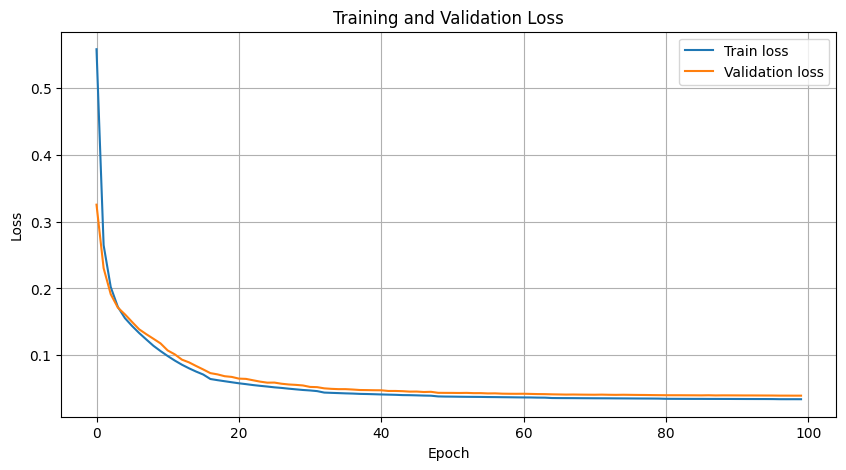

Final model saved as lorenz96/outputsnaive_network.pth


In [ ]:
epochs = 100
# Train the model
trainer = Trainer(model, train_loader, val_loader, mean, std,
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    model_type=model_type, dt=dt, F=F)
trainer.train(epochs=epochs, lr=1e-3)


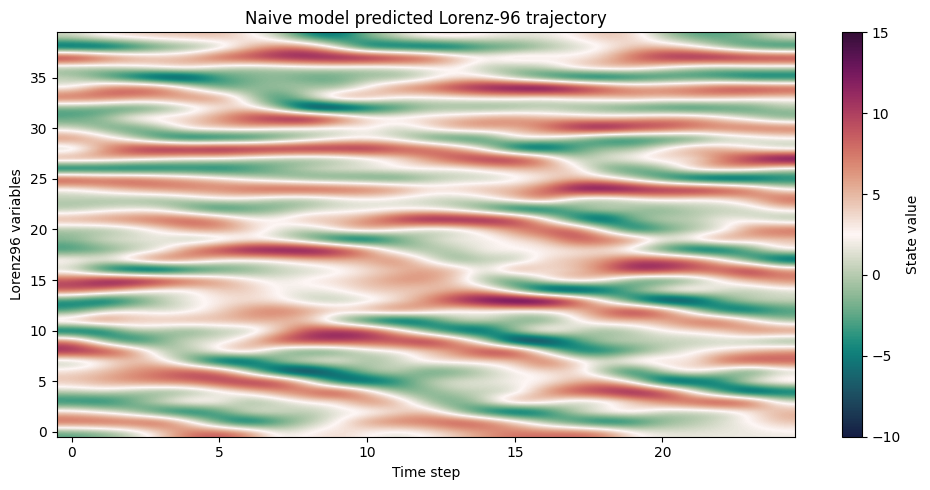

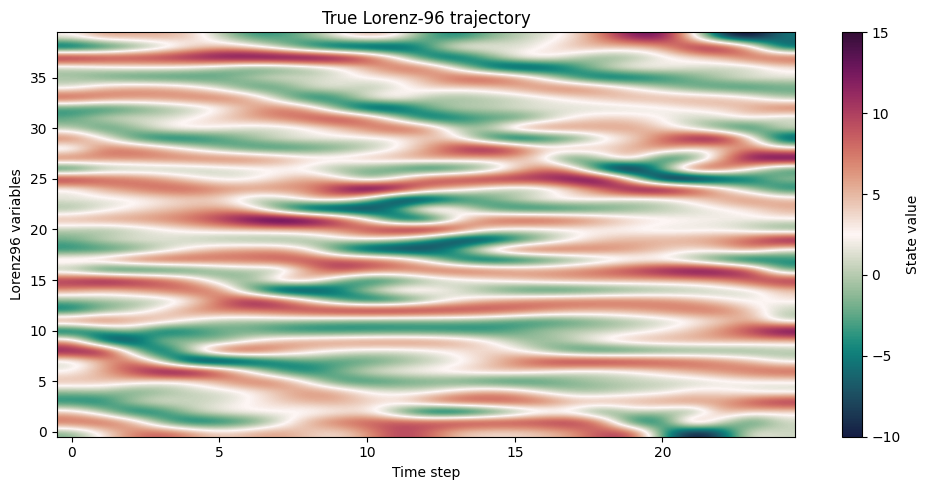

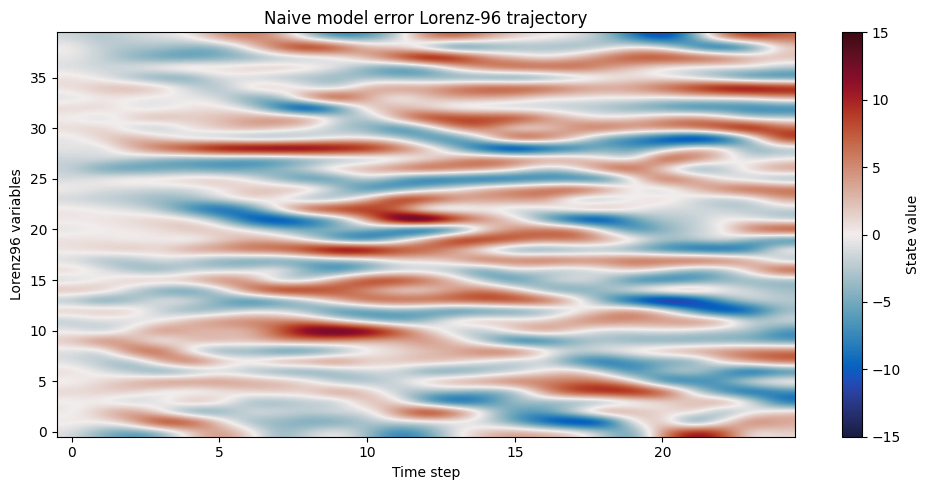

In [ ]:
Nt = 25

# Load the model, uncomment to load stored weights
# model.load_state_dict(torch.load(
#    f'{PATH}/stored/{model_type}/best_dt{dt}_Nx{Nx}_F{F}_network.pth', weights_only=True))

# Predictions
inference = Inference(model, mean, std, model_type=model_type,
                        device='cuda' if torch.cuda.is_available() else 'cpu')
inference.predict_trajectory(val_set, steps=Nt, Nx=true_model.Nx)

### 2. Convolutional neural network (CNN)
A convolutional neural network that takes the state $x_t$ as input and outputs the state $x_{t+1}$ at the next time step.

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, Nx, num_filters=64, kernel_size=5):
        super(ConvolutionalNetwork, self).__init__()
        self.Nx = Nx

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters,
                               kernel_size=kernel_size, padding=kernel_size//2)
        self.conv4 = nn.Conv1d(in_channels=num_filters, out_channels=1,
                               kernel_size=kernel_size, padding=kernel_size//2)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Add channel dimension and apply convolutions
        x = x.unsqueeze(1)  # (B, 1, Nx) -- Add channel dimension
        x = self.relu(self.conv1(x))  # Apply Conv1
        x = self.conv4(x)  # Apply Conv4 to reduce to 1 channel
        return x.squeeze(1)  # Remove channel dimension and return (B, Nx)

    def predict(self, x, steps=1):
        """
        Predict the next state using the model for a given number of steps.
        """
        for _ in range(steps):
            x = self.forward(x)
        return x

In [12]:
model_type = 'conv'
model = ConvolutionalNetwork(
    Nx=true_model.Nx, num_filters=64, kernel_size=5)


Training on device: cpu
[Epoch 1] Train loss: 1.4210e-01 | Val loss: 4.2788e-02
[Epoch 2] Train loss: 3.5141e-02 | Val loss: 3.1031e-02
[Epoch 3] Train loss: 2.6795e-02 | Val loss: 2.4711e-02
[Epoch 4] Train loss: 2.1599e-02 | Val loss: 2.0917e-02
[Epoch 5] Train loss: 1.8633e-02 | Val loss: 1.8797e-02
[Epoch 6] Train loss: 1.6902e-02 | Val loss: 1.7442e-02
[Epoch 7] Train loss: 1.5743e-02 | Val loss: 1.6498e-02
[Epoch 8] Train loss: 1.4908e-02 | Val loss: 1.5776e-02
[Epoch 9] Train loss: 1.4238e-02 | Val loss: 1.5208e-02
[Epoch 10] Train loss: 1.3748e-02 | Val loss: 1.4757e-02
[Epoch 11] Train loss: 1.3327e-02 | Val loss: 1.4407e-02
[Epoch 12] Train loss: 1.2989e-02 | Val loss: 1.4122e-02
[Epoch 13] Train loss: 1.2719e-02 | Val loss: 1.3897e-02
[Epoch 14] Train loss: 1.2490e-02 | Val loss: 1.3641e-02
[Epoch 15] Train loss: 1.2262e-02 | Val loss: 1.3447e-02
[Epoch 16] Train loss: 1.2094e-02 | Val loss: 1.3314e-02
[Epoch 17] Train loss: 1.1932e-02 | Val loss: 1.3178e-02
[Epoch 18] Train

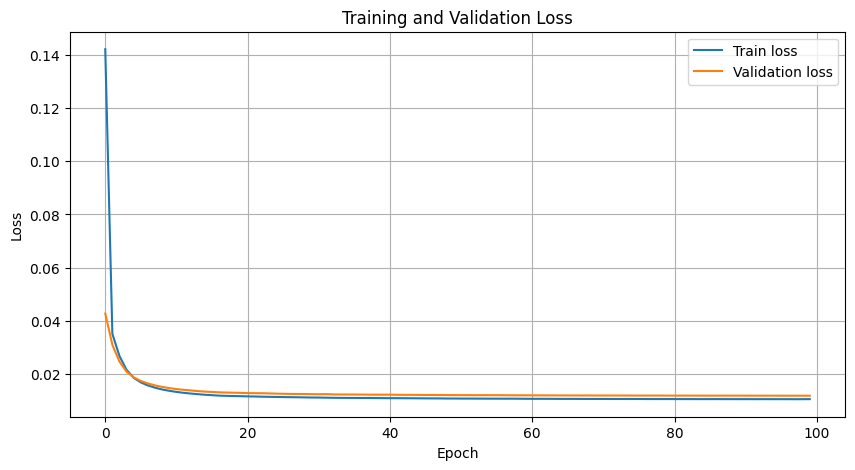

Final model saved as lorenz96/outputsconv_network.pth


In [ ]:
epochs = 100
# Train the model
trainer = Trainer(model, train_loader, val_loader, mean, std,
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    model_type=model_type, dt=dt, F=F)
trainer.train(epochs=epochs, lr=1e-3)


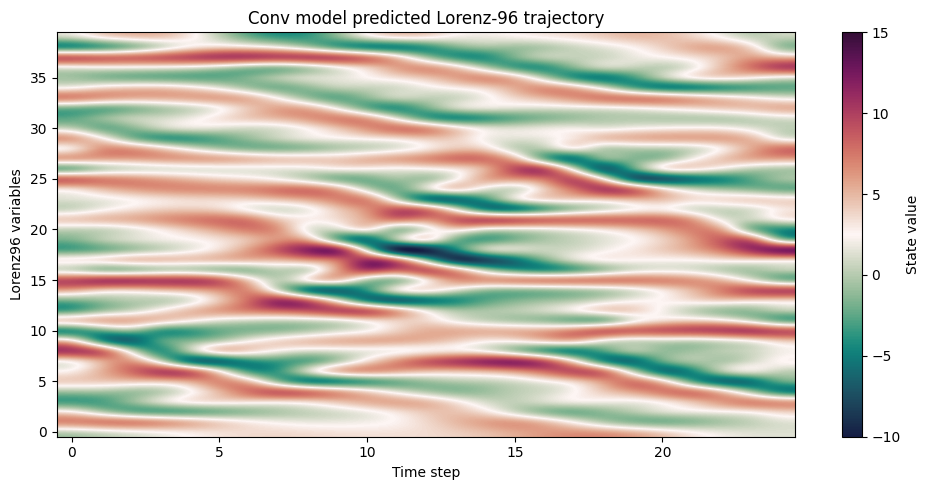

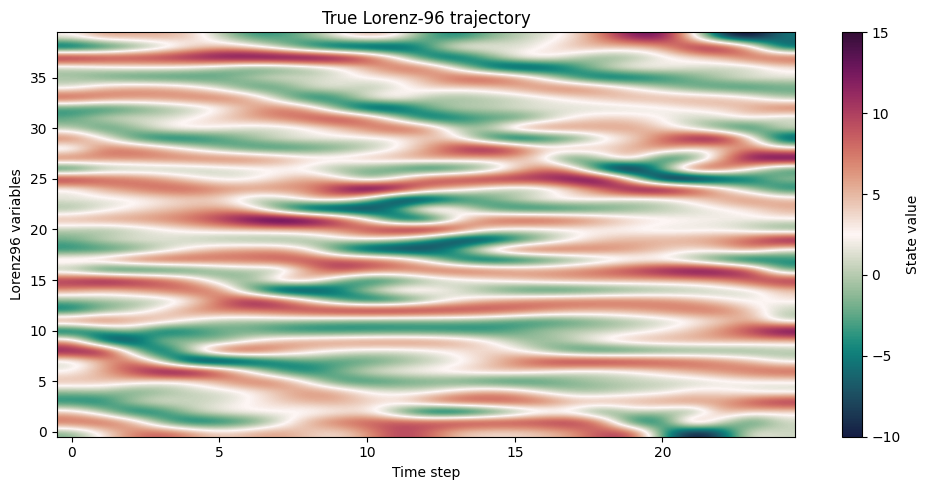

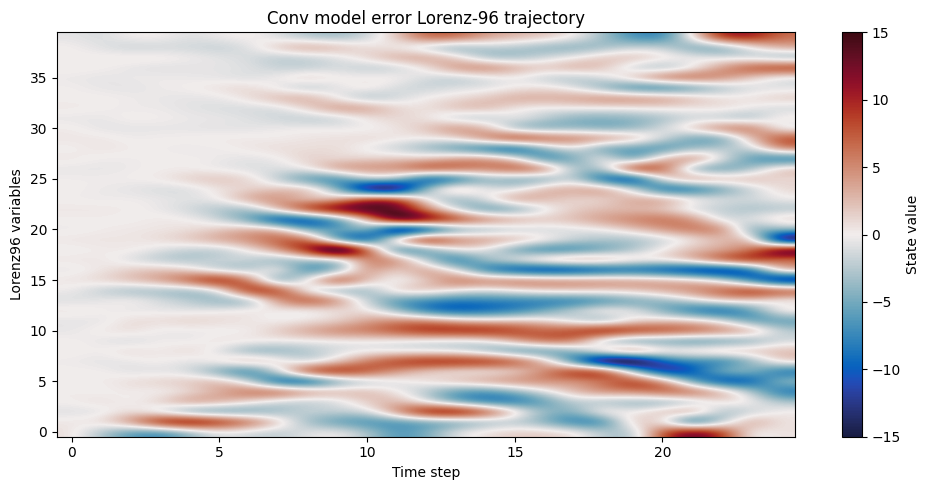

In [ ]:
Nt = 25

# Load the model, uncomment to load stored weights
# model.load_state_dict(torch.load(
#    f'{PATH}/stored/{model_type}/best_dt{dt}_Nx{Nx}_F{F}_network.pth', weights_only=True))

# Predictions
inference = Inference(model, mean, std, model_type=model_type,
                        device='cuda' if torch.cuda.is_available() else 'cpu')
inference.predict_trajectory(val_set, steps=Nt, Nx=true_model.Nx)

### 3. Hybrid model
A hybrid model that combines: a CNN-based architecture for computing the tendency $\frac{dx}{dt}$, an explicit integration scheme (Euler, RK2, RK4), and periodic padding to enforce spatial boundary conditions.

- The **tendency** term approximate a learnable physical tendency function, inspired by differential equations with nonlinear terms. This means that we don't need to hard-code the theoretical tendency. Instead, we can learn it from the data. 

In [15]:
class HybridNetwork(nn.Module):
    def __init__(self, Nx, num_filters=6, kernel_size=5, dt=0.01, integrator='euler'):
        super(HybridNetwork, self).__init__()
        self.Nx = Nx
        self.dt = dt
        self.border = kernel_size // 2
        self.integrator = integrator

        # Convolutional layers
        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=num_filters * 2,
                               out_channels=1, kernel_size=1)

    def pad(self, x):
        # Periodic padding
        left = x[..., -self.border:]
        right = x[..., :self.border]
        return torch.cat([left, x, right], dim=-1)

    def tendency(self, x):
        x = x.unsqueeze(1)  # (B, 1, Nx)
        x_pad = self.pad(x)  # Periodic padding

        x1 = self.conv1(x_pad)  # (B, F, Nx)
        x2 = x1 ** 2            # Quadratic nonlinearity

        x_cat = torch.cat([x1, x2], dim=1)  # (B, 2F, Nx)
        out = self.conv2(x_cat)             # (B, 1, Nx)

        return out.squeeze(1)               # (B, Nx)

    def forward(self, x):
        if self.integrator == 'euler':
            return self.euler_step(x)
        elif self.integrator == 'rk2':
            return self.rk2_step(x)
        elif self.integrator == 'rk4':
            return self.rk4_step(x)
        else:
            raise ValueError(
                "Invalid integrator. Use 'euler', 'rk2', or 'rk4'.")

    def euler_step(self, x):
        """
        Euler integration step.
        """
        dx = self.tendency(x)
        return x + self.dt * dx

    def rk2_step(self, x):
        """
        Runge-Kutta 2nd order integration
        """
        k1 = self.tendency(x)
        k2 = self.tendency(x + self.dt * k1)
        dx = (k1 + k2) / 2
        return x + self.dt * dx

    def rk4_step(self, x):
        """
        Runge-Kutta 4th order integration
        """
        k1 = self.tendency(x)
        k2 = self.tendency(x + 0.5 * self.dt * k1)
        k3 = self.tendency(x + 0.5 * self.dt * k2)
        k4 = self.tendency(x + self.dt * k3)
        dx = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return x + self.dt * dx

    def predict(self, x, steps=1):
        """
        Predict the next state using the model for a given number of steps.
        """
        for _ in range(steps):
            x = self.forward(x)
        return x


In [ ]:

model_type="hybrid"
# hybrid network
# Use the same parameters as the true model
# Nx = true_model.Nx, dt = true_model.dt, integrator = true_model.integrator
model = HybridNetwork(Nx=Nx, num_filters=6,
                        kernel_size=5, dt=dt, integrator='rk4')


Training on device: cpu
[Epoch 1] Train loss: 2.4332e-01 | Val loss: 2.3028e-01
[Epoch 2] Train loss: 2.2401e-01 | Val loss: 1.9923e-01
[Epoch 3] Train loss: 1.8292e-01 | Val loss: 1.5612e-01
[Epoch 4] Train loss: 1.4176e-01 | Val loss: 1.2207e-01
[Epoch 5] Train loss: 1.1217e-01 | Val loss: 9.8926e-02
[Epoch 6] Train loss: 9.1218e-02 | Val loss: 8.0431e-02
[Epoch 7] Train loss: 7.2165e-02 | Val loss: 6.0719e-02
[Epoch 8] Train loss: 5.2188e-02 | Val loss: 4.2117e-02
[Epoch 9] Train loss: 3.6033e-02 | Val loss: 2.9356e-02
[Epoch 10] Train loss: 2.5339e-02 | Val loss: 2.1111e-02
[Epoch 11] Train loss: 1.8508e-02 | Val loss: 1.6046e-02
[Epoch 12] Train loss: 1.4593e-02 | Val loss: 1.3338e-02
[Epoch 13] Train loss: 1.2602e-02 | Val loss: 1.1999e-02
[Epoch 14] Train loss: 1.1630e-02 | Val loss: 1.1319e-02
[Epoch 15] Train loss: 1.1107e-02 | Val loss: 1.0905e-02
[Epoch 16] Train loss: 1.0757e-02 | Val loss: 1.0587e-02
[Epoch 17] Train loss: 1.0526e-02 | Val loss: 1.0433e-02
[Epoch 18] Train

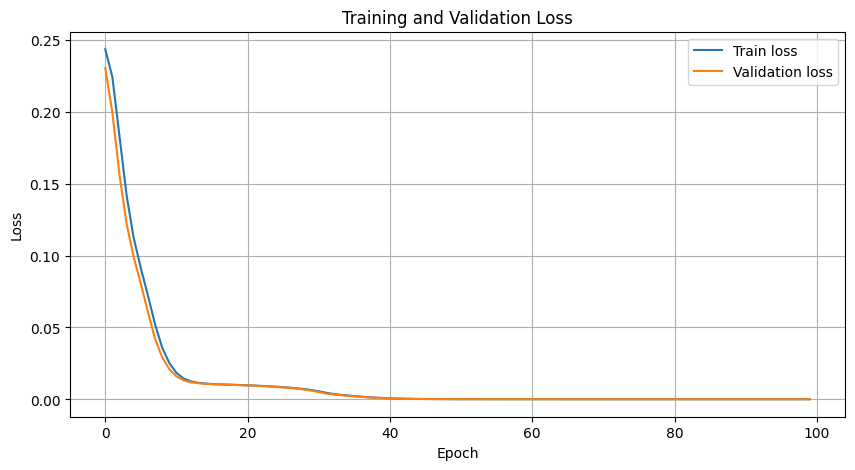

Final model saved as lorenz96/outputshybrid_network.pth


In [ ]:
epochs = 100
# Train the model
trainer = Trainer(model, train_loader, val_loader, mean, std,
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    model_type=model_type, dt=dt, F=F)
trainer.train(epochs=epochs, lr=1e-3)


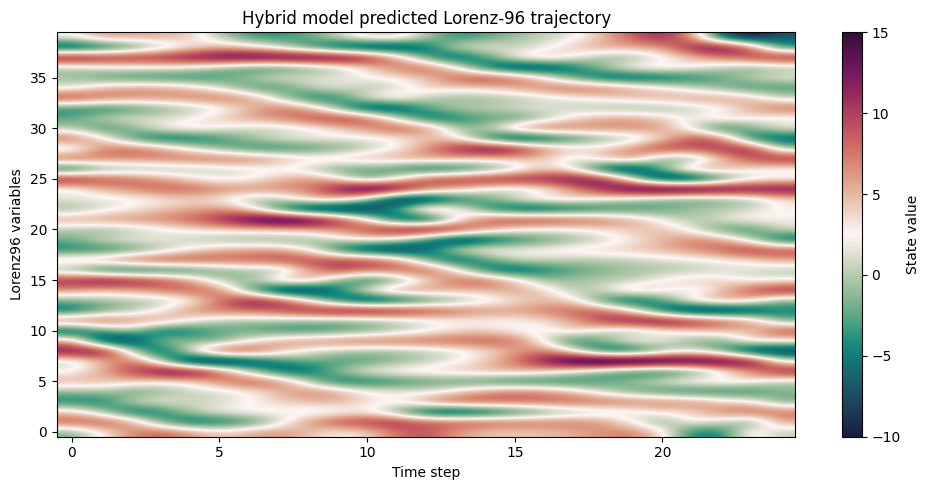

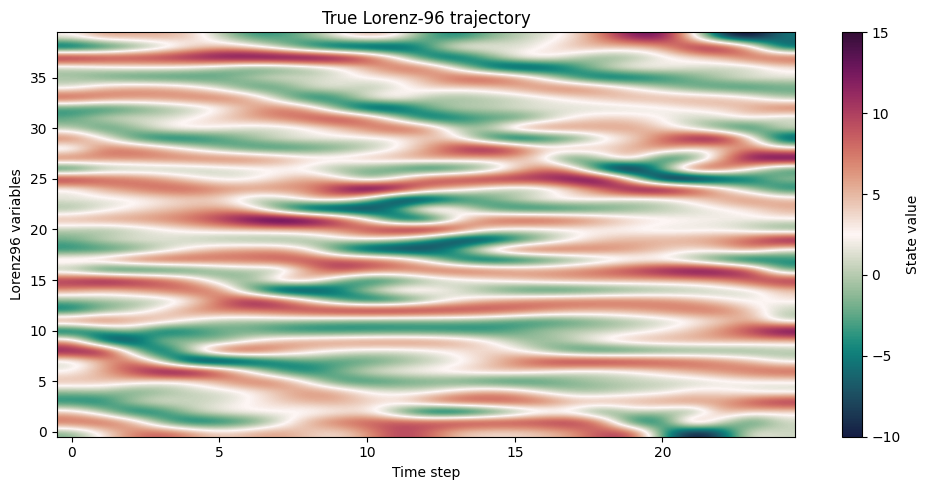

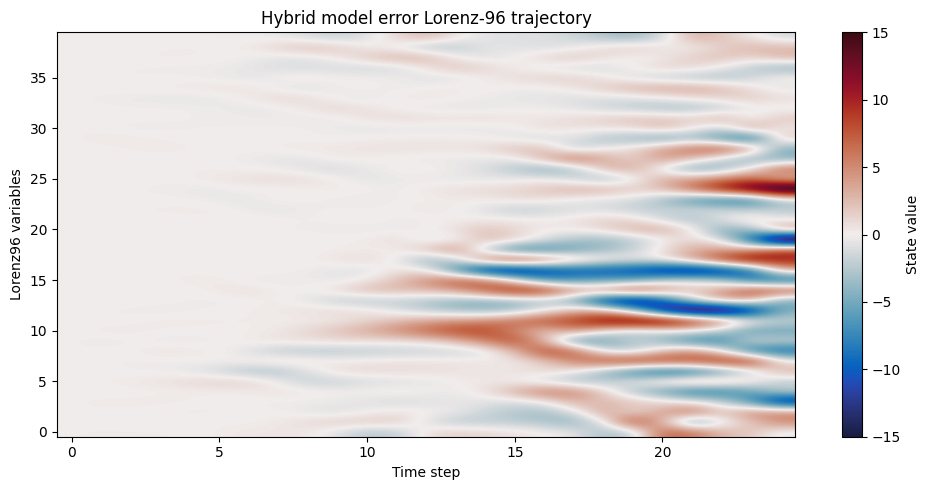

In [ ]:
Nt = 25

# Load the model, uncomment to load stored weights
# model.load_state_dict(torch.load(
#    f'{PATH}/stored/{model_type}/best_dt{dt}_Nx{Nx}_F{F}_network.pth', weights_only=True))

# Predictions
inference = Inference(model, mean, std, model_type=model_type,
                        device='cuda' if torch.cuda.is_available() else 'cpu')
inference.predict_trajectory(val_set, steps=Nt, Nx=true_model.Nx)

### Conclusion

In this practical session, we explored several neural network architectures for modelling the dynamics of chaotic systems.
The key takeaway is that incorporating domain knowledge—such as the structure of the underlying physical equations or the use of numerical integration schemes—can significantly enhance the performance and robustness of learned surrogate models.

These type of approaches are particularly relevant in the context of data assimilation, where surrogate models that respect physical laws are essential for reliable forecasting. This line of research is actively being pursued in operational weather and climate modelling, and it is expected to play an increasingly important role in the future of Earth system prediction.